In [1]:
from Data_Loader import load_data
from Train2 import trainCox_nnet

import torch
import numpy as np
import pandas as pd
from torch.utils.data.dataloader import DataLoader

In [2]:
dtype = torch.FloatTensor
''' Net Settings'''
In_Nodes = 58100 ###number of genes
Hidden_Nodes = 143 ###number of hidden nodes
Out_Nodes = 30 ###number of hidden nodes in the last hidden layer
''' Initialize '''
Initial_Learning_Rate = [0.03, 0.01, 0.001, 0.00075]
L2_Lambda = [0.1, 0.01, 0.005, 0.001]
num_epochs = 3 ###for grid search
Num_EPOCHS = 8 ###for training
###sub-network setup
Dropout_Rate = [0.7, 0.5]

In [3]:
from Data_extraction import output_df2, x_df2

In [4]:
print(np.shape(x_df2))
print(np.shape(output_df2))
# x_df2 = x_df2.reset_index(drop=True)
# output_df2 = output_df2.reset_index(drop=True)
x_df2.head()

(974, 58100)
(974, 5)


,0,1,2,3,4,5,6,7,8,9,...,60647,60648,60649,60651,60652,60654,60655,60656,60658,60659
filename,,,,,,,,,,,,,,,,,,,,,
00fabec9-d311-4994-a7e5-eb91178d14f2.rna_seq.augmented_star_gene_counts.tsv,6.5517,0.0000,40.7970,3.5529,2.3067,11.0530,5.9508,15.5682,30.8037,12.8685,...,0.2470,0.0,0.0000,0.3702,0.1793,0.0000,0.0,4.4250,0.0300,0.1190
011ccd6c-529a-4529-825d-ba024c13098d.rna_seq.augmented_star_gene_counts.tsv,51.5106,0.0000,42.6303,3.1611,1.2875,3.1909,14.7590,18.0684,9.5269,12.2742,...,0.0065,0.0,0.0000,0.0000,0.1703,0.0000,0.0,3.4802,0.0040,0.4275
0139ef5f-7adc-4e84-90c1-42ebf59aaf98.rna_seq.augmented_star_gene_counts.tsv,11.1571,0.0139,32.1374,3.8234,3.7916,5.7136,12.3892,9.7892,5.2389,9.6687,...,0.2619,0.0,0.0281,0.0000,0.1973,0.0000,0.0,5.5562,0.0170,0.4017
01c2d483-14b3-4a2e-b31c-c9b18cf68059.rna_seq.augmented_star_gene_counts.tsv,8.7361,0.0000,30.2099,3.1386,2.5484,0.5231,2.5403,11.1363,24.7778,10.7585,...,1.1504,0.0,0.0000,0.0000,0.1607,0.3412,0.0,6.6687,0.0065,0.1115
01d30473-7c6c-43ea-adf9-777c37917f88.rna_seq.augmented_star_gene_counts.tsv,6.0117,0.0000,36.0286,1.6381,1.9594,4.2518,6.5823,12.2504,11.6078,9.9054,...,0.1256,0.0,0.0000,0.0000,0.1351,0.0000,0.0,3.4635,0.0077,0.3844


In [5]:
# data = pd.concat([x_df2,output_df2],axis=1)
# # define a cross validation function
# def crossvalid(model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
#     train_score = pd.Series()
#     val_score = pd.Series()
    
#     total_size = len(dataset)
#     fraction = 1/k_fold
#     seg = int(total_size * fraction)
#     # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
#     # index: [trll,trlr],[vall,valr],[trrl,trrr]
#     for i in range(k_fold):
#         trll = 0
#         trlr = i * seg
#         vall = trlr
#         valr = i * seg + seg
#         trrl = valr
#         trrr = total_size
#         # msg
# #         print("train indices: [%d,%d),[%d,%d), test indices: [%d,%d)" 
# #               % (trll,trlr,trrl,trrr,vall,valr))
        
#         train_left_indices = list(range(trll,trlr))
#         train_right_indices = list(range(trrl,trrr))
        
#         train_indices = train_left_indices + train_right_indices
#         val_indices = list(range(vall,valr))
        
#         train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
#         val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
# #         print(len(train_set),len(val_set))
# #         print()
        
#         train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
#                                           shuffle=True, num_workers=4)
#         val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
#                                           shuffle=True, num_workers=4)
#         train_acc = train(res_model,criterion,optimizer,train_loader,epoch=1)
#         train_score.at[i] = train_acc
#         val_acc = valid(res_model,criterion,optimizer,val_loader)
#         val_score.at[i] = val_acc
    
#     return train_score,val_score
        

# train_score,val_score = crossvalid(res_model,criterion,optimizer,dataset=tiny_dataset)

In [5]:

data = pd.concat([x_df2,output_df2], axis=1)

def split_indices(n, val_pct1, val_pct2):
	n1 = int(val_pct1*n)
	n2 = int(val_pct2*n)
	idxs = np.random.permutation(n)
	train, val, test = idxs[:n1], idxs[n1:n2], idxs[n2:]
	train.sort(), val.sort(), test.sort()
	return(train, val, test)

# train_index, val_index, test_index = split_indices(len(data),0.6, 0.8)
# print(train_index)

# print(val_index)
# print(test_index)
x, ytime, yevent, age = load_data(data, dtype)

# data_train = data.iloc[train_index]
# data_val = data.iloc[val_index]
# data_test = data.iloc[test_index]
# x_train, ytime_train, yevent_train, age_train = load_data(data_train, dtype)
# x_valid, ytime_valid, yevent_valid, age_valid = load_data(data_val, dtype)
# x_test, ytime_test, yevent_test, age_test = load_data(data_test,dtype)

In [6]:

# print(data.head)
# import matplotlib.pyplot as plt
# plt.plot(x[500])


In [6]:
from Data_Loader import CustomDataset
batch_size=32
data2 = CustomDataset(x, ytime, yevent, age)
# train_loader = DataLoader(data2, batch_size, sampler=train_index)
# val_loader = DataLoader(data2, batch_size, sampler=val_index)

In [22]:
print(data2[10:20])

(tensor([[2.7949e+03, 0.0000e+00, 1.8186e+03,  ..., 1.5487e+02, 0.0000e+00,
         2.2642e+01],
        [5.1353e+03, 0.0000e+00, 4.0601e+03,  ..., 3.4792e+02, 2.4792e+00,
         9.0905e+00],
        [7.9838e+03, 1.9300e+02, 2.1274e+03,  ..., 2.5073e+02, 3.4465e+00,
         1.0339e+01],
        ...,
        [4.2617e+03, 3.8778e+00, 3.4071e+03,  ..., 1.8148e+02, 1.5511e+00,
         8.5312e+00],
        [1.2357e+03, 1.2507e+00, 1.3045e+03,  ..., 1.7761e+02, 5.0030e+00,
         2.2513e+01],
        [4.2319e+03, 1.1604e+00, 1.3031e+03,  ..., 1.2532e+02, 3.4811e+00,
         2.4368e+01]]), tensor([[4570.],
        [4261.],
        [4068.],
        [4053.],
        [4026.],
        [3940.],
        [3924.],
        [3850.],
        [3838.],
        [3759.]]), tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]]), tensor([[23171.],
        [20632.],
        [28001.],
        [25788.],
        [27555.]

In [7]:
opt_l2_loss = 0
opt_lr_loss = 0
opt_do_loss = 0
opt_loss = torch.Tensor([float("Inf")])
###if gpu is being used
if torch.cuda.is_available():
	opt_loss = opt_loss.cuda()
###
opt_c_index_va = 0
opt_c_index_tr = 0

In [8]:
print(len(x[0]))
print(len(yevent))

58100
974


In [9]:
for l2 in L2_Lambda:
	for lr in Initial_Learning_Rate:
		for do in Dropout_Rate:
			history_train, history_val = trainCox_nnet(data2, \
				In_Nodes, Hidden_Nodes, Out_Nodes, \
				lr, l2, num_epochs, do, batch_size)
			loss_train2 = [k['loss'] for k in history_train[1]]
			if loss_train2[-1] =='nan': 
				break
			elif loss_train2[-1] < opt_loss:
				opt_l2_loss = l2
				opt_lr_loss = lr
				opt_do_loss = do
				opt_loss = loss_train2[-1]
				# opt_c_index_tr = c_index_tr
				# opt_c_index_va = c_index_va
			print ("L2: ", l2, "LR: ", lr, "Loss in Validation: ", opt_loss)

------------fold no---------0----------------------
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch training tensor([nan], grad_fn=<ReshapeAliasBackward0>)
loss batch

KeyboardInterrupt: 

In [8]:
opt_l2_loss, opt_lr_loss, opt_do_loss = 0.001, 0.00075, 0.5

#print(opt_l2_loss, opt_lr_loss, opt_do_loss)

In [9]:
###train Cox-PASNet with optimal hyperparameters using train data, and then evaluate the trained model with test data
###Note that test data are only used to evaluate the trained Cox-nnet
history_train, history_val = trainCox_nnet(data2, \
			In_Nodes, Hidden_Nodes, Out_Nodes, \
			opt_lr_loss, opt_l2_loss, Num_EPOCHS, opt_do_loss, batch_size)
print ("Optimal L2: ", opt_l2_loss, "Optimal LR: ", opt_lr_loss)
# print("C-index in Test: ", c_index_te)

------------fold no---------0----------------------
Epoch [0], loss: 2.5955, c_index: 0.5542
Epoch [1], loss: 2.5432, c_index: 0.5527
Epoch [2], loss: 2.5560, c_index: 0.5530
Epoch [3], loss: 2.6197, c_index: 0.5630
Epoch [4], loss: 2.6436, c_index: 0.5640
Epoch [5], loss: 2.4747, c_index: 0.5606
Epoch [6], loss: 2.6651, c_index: 0.5507
Epoch [7], loss: 2.8519, c_index: 0.5796
Epoch [8], loss: 2.7373, c_index: 0.6219
------------fold no---------1----------------------
Epoch [0], loss: 2.3493, c_index: 0.6177
Epoch [1], loss: 2.4791, c_index: 0.6166
Epoch [2], loss: 2.4451, c_index: 0.6152
Epoch [3], loss: 2.3600, c_index: 0.6182
Epoch [4], loss: 2.3366, c_index: 0.6317
Epoch [5], loss: 2.3951, c_index: 0.6146
Epoch [6], loss: 2.4267, c_index: 0.4818
Epoch [7], loss: 2.5873, c_index: 0.4689
Epoch [8], loss: 2.7376, c_index: 0.4431
------------fold no---------2----------------------
Epoch [0], loss: 2.6862, c_index: 0.5502
Epoch [1], loss: 2.8817, c_index: 0.5476
Epoch [2], loss: 2.7459,

In [10]:
loss_train_fold0 = [k['loss'] for k in history_train[0]]
loss_val_fold0 = [k['loss'] for k in history_val[0]] 
c_index_train_fold0 = [k['c_index'] for k in history_train[0]]
c_index_val_fold0 = [k['c_index'] for k in history_val[0]]

loss_train_fold1 = [k['loss'] for k in history_train[1]]
loss_val_fold1 = [k['loss'] for k in history_val[1]] 
c_index_train_fold1 = [k['c_index'] for k in history_train[1]]
c_index_val_fold1 = [k['c_index'] for k in history_val[1]]

loss_train_fold2 = [k['loss'] for k in history_train[2]]
loss_val_fold2 = [k['loss'] for k in history_val[2]] 
c_index_train_fold2 = [k['c_index'] for k in history_train[2]]
c_index_val_fold2 = [k['c_index'] for k in history_val[2]]

loss_train_fold3 = [k['loss'] for k in history_train[3]]
loss_val_fold3 = [k['loss'] for k in history_val[3]] 
c_index_train_fold3 = [k['c_index'] for k in history_train[3]]
c_index_val_fold3 = [k['c_index'] for k in history_val[3]]

loss_train_fold4 = [k['loss'] for k in history_train[4]]
loss_val_fold4 = [k['loss'] for k in history_val[4]] 
c_index_train_fold4 = [k['c_index'] for k in history_train[4]]
c_index_val_fold4 = [k['c_index'] for k in history_val[4]]


In [15]:
#result cross validation
print(np.mean([c_index_val_fold0[2], c_index_val_fold1[2], c_index_val_fold2[2], c_index_val_fold3[2]]))
# print(np.mean([c_index_val_fold0[3], c_index_val_fold1[3], c_index_val_fold2[3], c_index_val_fold3[3]]))

0.5337160006165504


In [31]:
print(history_train)

[[{'loss': 3.0324854850769043, 'c_index': 0.5139650106430054}], [{'loss': 3.932288408279419, 'c_index': 0.5035215616226196}], [], [], []]


In [11]:
# loss_train2 = [k['loss'] for k in history_train]
# loss_val2 = [k['loss'] for k in history_val] 
# c_index_tr2 = [k['c_index'] for k in history_train]
# c_index_val2 = [k['c_index'] for k in history_val]

epoch = np.arange(0,Num_EPOCHS+1)


In [12]:
# loss_train2 = [k.detach().numpy() for k in loss_train]
# loss_test2 = [k.detach().numpy() for k in loss_test]
# c_index_tr2 = [k.detach().numpy() for k in c_index_tr]
# c_index_te2 = [k.detach().numpy() for k in c_index_te]
# epoch = np.arange(0,Num_EPOCHS+2,2)

In [20]:
# print(loss_train2)
# print(len(yevent_train))
print(loss_val_fold4)

[2.672226667404175, 2.652674436569214, 2.549652338027954, 2.382066011428833, 2.383145570755005, 2.443861484527588, 2.437490224838257, 2.5582664012908936, 2.4949355125427246]


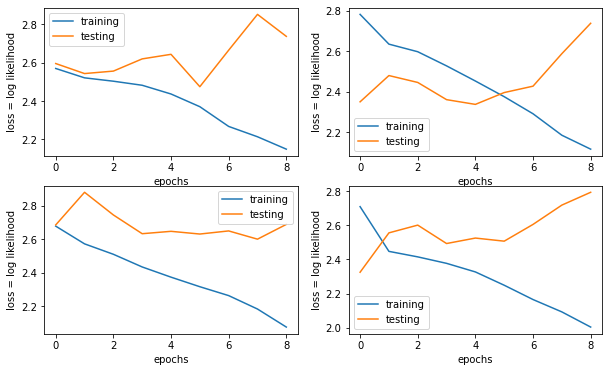

In [12]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(epoch, loss_train_fold0, label = 'training')
plt.plot(epoch, loss_val_fold0, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(222)
plt.plot(epoch, loss_train_fold1, label = 'training')
plt.plot(epoch, loss_val_fold1, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(223)
plt.plot(epoch, loss_train_fold2, label = 'training')
plt.plot(epoch, loss_val_fold2, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(224)
plt.plot(epoch, loss_train_fold3, label = 'training')
plt.plot(epoch, loss_val_fold3, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()



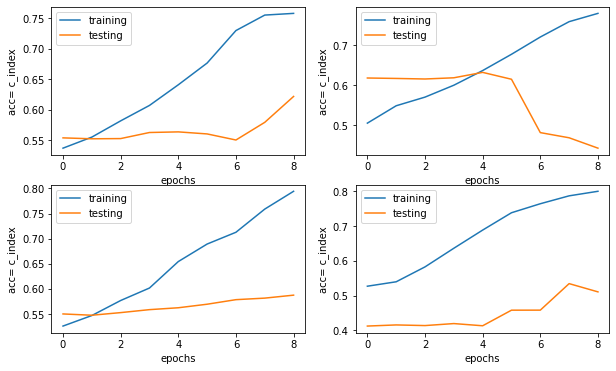

In [14]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(epoch, c_index_train_fold0, label = 'training')
plt.plot(epoch, c_index_val_fold0, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(222)
plt.plot(epoch, c_index_train_fold1, label = 'training')
plt.plot(epoch, c_index_val_fold1, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(223)
plt.plot(epoch, c_index_train_fold2, label = 'training')
plt.plot(epoch, c_index_val_fold2, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(224)
plt.plot(epoch, c_index_train_fold3, label = 'training')
plt.plot(epoch, c_index_val_fold3, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()


In [ ]:
print(c_index_te[-1])

NameError: name 'c_index_te' is not defined

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [ ]:
get_default_device()

device(type='cpu')

In [13]:
from Survival_CostFunc_CIndex import R_set, neg_par_log_likelihood, c_index
from Model2 import Cox_nnet

net = Cox_nnet(In_Nodes, Hidden_Nodes, Out_Nodes, 0.5)
net.eval()
data_test = data.iloc[test_index]
x_test, ytime_test, yevent_test, age_test = load_data(data_test,dtype)
test_pred=net(x_test, age_test)
eval_loss = []
eval_cindex=[]
eval_loss.append(neg_par_log_likelihood(test_pred, ytime_test, yevent_test).view(1,))
eval_cindex.append(c_index(test_pred, ytime_test, yevent_test))

c:\Users\anais\Documents\2-Imperial\0-Research-Project\4-NN\Cox-nnet model\src\Data_Loader.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_to_death']= np.where(data['days_to_death'] == "'--", data['days_to_last_follow_up'],data['days_to_death'])
c:\Users\anais\Documents\2-Imperial\0-Research-Project\4-NN\Cox-nnet model\src\Data_Loader.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_to_death']=data['days_to_death'].astype(float)
c:\Users\anais\Documents\2-Imperial\0-Research-P

In [14]:
print(eval_loss, eval_cindex)

[tensor([37.4788], grad_fn=<ViewBackward0>)] [tensor(0.4685)]
